In [1]:
import numpy as np
import shap
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [2]:
data1 = pd.read_excel('Column_database.xlsx', sheet_name='ColumnDataBase')
data1.head()

,Reference,Specimen,Failure,a/D,ALF,ρlfy/fc,ρvfyv/ft,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Davey 1975,No. 1,1,5.50,0.055265,0.288491,0.368768,NaN,NaN,NaN
1,NaN,No. 2,1,3.50,0.052724,0.273751,0.360191,NaN,Note,"Test configuration: C = cantilever, DC = doubl..."
2,NaN,No. 3,1,6.50,0.054284,0.283370,0.400623,NaN,NaN,NaN
3,Munro et al. 1976,No. 1,1,5.46,0.003187,0.195795,1.213041,NaN,NaN,# flexure columns = 221 (represented as 1 in F...
4,Ng et al. 1978,No. 2,1,5.36,0.011396,0.222759,1.289995,NaN,NaN,# flexure-shear columns = 53 (FS - 2)


In [3]:
data=data1.loc[:, 'Failure':'ρvfyv/ft']
data.head()

,Failure,a/D,ALF,ρlfy/fc,ρvfyv/ft
0,1,5.50,0.055265,0.288491,0.368768
1,1,3.50,0.052724,0.273751,0.360191
2,1,6.50,0.054284,0.283370,0.400623
3,1,5.46,0.003187,0.195795,1.213041
4,1,5.36,0.011396,0.222759,1.289995


In [4]:
# Generate X and y data
X = data.loc[:, data.columns != 'Failure'].to_numpy()
y =data['Failure'].to_numpy()
#X.head()

In [5]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
len(X_test), len(X_train)

(95, 221)

In [7]:
# Isolate our examples for our columns data that have labels
n_labeled_examples = X_train.shape[0]
size = 10 #Intial Samples
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size =10)

In [8]:
training_indices

array([109, 126,  66, 220,  98,  17,  83, 106, 123,  57])

In [9]:
X_train_new = X_train[training_indices]
y_train_new = y_train[training_indices]

In [10]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_train, training_indices, axis=0)
y_pool = np.delete(y_train, training_indices, axis=0)

In [11]:
from xgboost import XGBClassifier
from modAL.models import ActiveLearner

# Specify the core estimator along with it's active learning model.
XGB = XGBClassifier()
learner = ActiveLearner(estimator=XGB, X_training=X_train_new, y_training=y_train_new)

In [12]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_train)
is_correct = (predictions == y_train)

In [13]:
learner.score(X_train, y_train)

0.6968325791855203

In [14]:
y_train.dtype

dtype('int64')

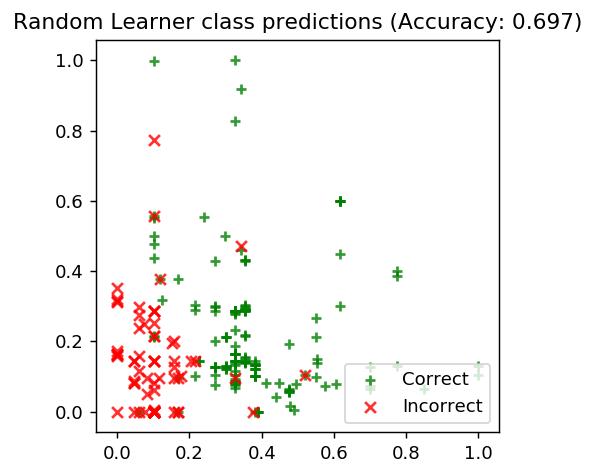

In [15]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_train, y_train)
unqueried_score_test = learner.score(X_test, y_test)


# Plot our classification results.
fig, ax = plt.subplots(figsize=(4, 4), dpi=130)
ax.scatter(x=X_train[is_correct][:,0],  y=X_train[is_correct][:,1],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=X_train[~is_correct][:,0], y=X_train[~is_correct][:,1], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("Random Learner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [16]:
learner.query(X_pool)

(array([0], dtype=int64),
 array([[0.35459184, 0.28738835, 0.01211558, 0.33760417]]))

# Random Sampling

In [17]:
#N_QUERIES = len(X_train)-size
from random import randrange
N_QUERIES = 100
performance_history = [unqueried_score]
performance_history_test = [unqueried_score_test]
# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
    
    
    query_index = randrange(len(X_pool))
    query_instance=X_pool[query_index]

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy on training data.
    model_accuracy = learner.score(X_train, y_train)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Calculate and report our model's accuracy on training data.
    model_accuracy_test = learner.score(X_test, y_test)

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    performance_history_test.append(model_accuracy_test)

Accuracy after query 1: 0.6968
Accuracy after query 2: 0.6968
Accuracy after query 3: 0.6968
Accuracy after query 4: 0.6968
Accuracy after query 5: 0.6968
Accuracy after query 6: 0.6968
Accuracy after query 7: 0.6968
Accuracy after query 8: 0.6968
Accuracy after query 9: 0.7511
Accuracy after query 10: 0.7511
Accuracy after query 11: 0.7511
Accuracy after query 12: 0.7511
Accuracy after query 13: 0.7873
Accuracy after query 14: 0.7692
Accuracy after query 15: 0.7692
Accuracy after query 16: 0.7692
Accuracy after query 17: 0.7919
Accuracy after query 18: 0.7919
Accuracy after query 19: 0.7919
Accuracy after query 20: 0.7919
Accuracy after query 21: 0.7919
Accuracy after query 22: 0.7964
Accuracy after query 23: 0.8235
Accuracy after query 24: 0.8235
Accuracy after query 25: 0.8371
Accuracy after query 26: 0.8326
Accuracy after query 27: 0.8190
Accuracy after query 28: 0.8190
Accuracy after query 29: 0.8281
Accuracy after query 30: 0.8281
Accuracy after query 31: 0.8371
Accuracy after qu

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


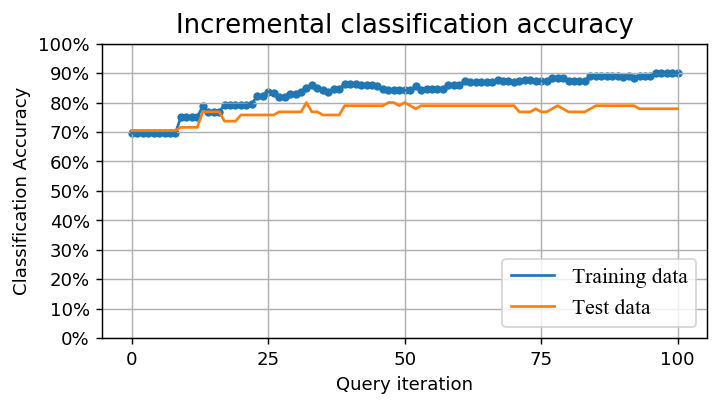

In [18]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(6, 3), dpi=130)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.plot(performance_history_test)



ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

ax.legend(('Training data', 'Test data'),loc='lower right')

plt.savefig('column_active_learning_random_sampling.eps',format='eps', dpi=1000)
plt.show()

In [19]:
y_pred_train = learner.predict(X_train)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_train, y_pred_train)
print(confusion_matrix)

[[152   2   0]
 [ 10  24   2]
 [  1   7  23]]


In [22]:
print('Accuracy of RF classifier on train set: {:.2f}'
     .format(learner.score(X_train, y_train)))

Accuracy of RF classifier on train set: 0.90


In [23]:
y_pred_test = learner.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix_test)

[[64  2  1]
 [10  6  1]
 [ 2  5  4]]


In [24]:
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(learner.score(X_test, y_test)))

Accuracy of RF classifier on test set: 0.78
